## TRAPI query results

In [105]:
import requests
import json

import pprint
pp = pprint.PrettyPrinter(indent=5)

search_string = 'Buprenorphine'
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={search_string}&offset=0&limit=10')
results_json = results.json()
input_node_id_list = list(results_json.keys())

nn_query = {
  "curies": input_node_id_list,
  "conflate": True
}

results = requests.post('https://nodenormalization-sri.renci.org/get_normalized_nodes',json=nn_query)

query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": input_node_id_list,
            "categories": ["biolink:ChemicalEntity"]
          },
          "n01": {
              "categories": ["biolink:BiologicalProcessOrActivity","biolink:Gene","biolink:Pathway"]
          },
          "n02": {
            "ids": ["HP:0001337"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }

robokop_submit_url = "https://automat.renci.org/robokopkg/1.3/query"
response = requests.post(robokop_submit_url,json=query)
print(response.status_code)
number_pathway_results = len(response.json()['message']['results'])
print(len(response.json()['message']['results']))

200
8


In [28]:
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/TRAPI",str(dt_string))
write_dir.mkdir(parents=True, exist_ok=True)

In [106]:
import pandas as pd
from pathlib import Path

nodes = response.json()['message']['results'][0]['node_bindings'].keys()
output_dict = {}
for key in nodes:
    output_dict[key] = {}
    
i = 0
for entry in response.json()['message']['results']:
    # for edge_id in edges:
    #     output_dict[edge_id][i] = entry['edge_bindings'][edge_id][0]['id']
    for node_id in nodes:
        output_dict[node_id][i] = entry['node_bindings'][node_id][0]['id']
    i = i + 1
    
node_list = [x for x in output_dict.keys() if 'n' in x]

for node_id in node_list:
    for node_index, node_value in output_dict[node_id].items():
        # Getting the 'name' label using the node ID from the knowledge graph
        output_dict[node_id][node_index] = response.json()['message']['knowledge_graph']['nodes'][node_value]['name']
        
pp.pprint(output_dict)
json_str = json.dumps(output_dict, indent=4)
df = pd.read_json(json_str)
cols = df.columns.tolist()
cols.sort()
df = df[cols]
df.to_csv(Path(write_dir,'pathways_TRAPI_automat.csv'))

combined_node_list = ["_".join([row[0].replace(" ", "_"), row[1].replace(" ", "_"), row[2].replace(" ", "_")]) for row in df[cols].to_numpy()]
pp.pprint(combined_node_list)

{    'n00': {    0: 'Buprenorphine',
                 1: 'Buprenorphine',
                 2: 'Buprenorphine',
                 3: 'Buprenorphine',
                 4: 'Buprenorphine',
                 5: 'Brixadi',
                 6: 'Buprenorphine',
                 7: 'Buprenorphine'},
     'n01': {    0: 'CYP2D6',
                 1: 'CYP2D6',
                 2: 'CYP2D6',
                 3: 'CYP2D6',
                 4: 'OPRM1',
                 5: 'OPRM1',
                 6: 'CYP2D6',
                 7: 'CYP2D6'},
     'n02': {    0: 'Limb tremor',
                 1: 'Pill-rolling tremor',
                 2: 'Tremor',
                 3: 'Postural tremor',
                 4: 'Asterixis',
                 5: 'Asterixis',
                 6: 'Resting tremor',
                 7: 'Action tremor'}}


In [107]:
colnames = df.columns.values.tolist()
colnames.sort()

combined_node_list = ["_".join([row[0].replace(" ", "_"), row[1].replace(" ", "_"), row[2].replace(" ", "_")]) for row in df[colnames].to_numpy()]
# pp.pprint(combined_node_list)
for node_set in combined_node_list:
    print(os.path.join(write_dir,node_set+".txt"))

output\Cypher_automat\2023-03-29_081046\Buprenorphine_CYP2D6_Limb_tremor.txt
output\Cypher_automat\2023-03-29_081046\Buprenorphine_CYP2D6_Pill-rolling_tremor.txt
output\Cypher_automat\2023-03-29_081046\Buprenorphine_CYP2D6_Tremor.txt
output\Cypher_automat\2023-03-29_081046\Buprenorphine_CYP2D6_Postural_tremor.txt
output\Cypher_automat\2023-03-29_081046\Buprenorphine_OPRM1_Asterixis.txt
output\Cypher_automat\2023-03-29_081046\Brixadi_OPRM1_Asterixis.txt
output\Cypher_automat\2023-03-29_081046\Buprenorphine_CYP2D6_Resting_tremor.txt
output\Cypher_automat\2023-03-29_081046\Buprenorphine_CYP2D6_Action_tremor.txt


In [108]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results):
    # if i >= 1:
        # break
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = response.json()['message']['results'][i]['edge_bindings']
    # print(edge_bindings)

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    # print(edge_ids)
    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            # print(f"{edge_name}: {edge_list}")
            for edge_id in edge_list:
                subject_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['subject']
                subject = response.json()['message']['knowledge_graph']['nodes'][subject_id]['name']
                predicate = response.json()['message']['knowledge_graph']['edges'][edge_id]['predicate']
                object_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['object']
                object = response.json()['message']['knowledge_graph']['nodes'][object_id]['name']
                # print(f"\t{subject} -> {predicate} -> {object}")
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
                # if edge_name == 'e01':
                #     print(response.json()['message']['knowledge_graph']['edges'][edge_id]['attributes'])
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir,combined_node_list[i]+".txt"), 'w') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

Pathway result: Buprenorphine_CYP2D6_Limb_tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Limb tremor': 1}

Pathway result: Buprenorphine_CYP2D6_Pill-rolling_tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Pill-rolling tremor': 1}

Pathway result: Buprenorphine_CYP2D6_Tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}

Pathway result: Buprenorphine_CYP2D6_Postural_tremor
{    'Buprenorphine -> biolink:a

## Cypher query results (automat.renci.org)

In [84]:
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/Cypher_automat",str(dt_string))
write_dir.mkdir(parents=True, exist_ok=True)

In [110]:
cypher = f"MATCH (n0_0:`biolink:ChemicalEntity`)-[r0_0]-(n1_0:`biolink:Gene`)-[r1_0]-(n2_0:`biolink:DiseaseOrPhenotypicFeature`) WHERE n0_0.name IN ['Buprenorphine'] AND n2_0.name IN ['Tremor'] RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, [n0_0.name, n1_0.name, n2_0.name] as node_names LIMIT 100"

j = {'query': cypher}
results = requests.post('https://automat.renci.org/robokopkg/cypher',json=j)
results_json = results.json()
print(results_json['results'][0]['columns'])
column_names = results_json['results'][0]['columns']
print(results.status_code)

['edge_1', 'edge_2', 'node_names']
200


In [119]:
i = 0

string_out_list = []
for result in results_json['results'][0]['data']:
    # print(f'Result: {i+1}')
    j = 0
    for item in result['row'][0:2]:
        # print(item)
        # print(f"{column_names[j]}: {item[0]['name']} -> {item[1][0]} -> {item[2]['name']}")
        # print(f"Edge properties: {item[1][1]}\n")
        # print(f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}")
        # string_out = f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}"
        string_out_test = f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}||{item[1][1]}"
        if string_out_test not in string_out_list:
            string_out_list.append(string_out_test)
        j = j + 1
    # print("")

    i = i + 1
    # if i > 0:
    #     break
    
combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
print(combined_node_list)

string_out_list = [i.split('||', 1)[0] for i in string_out_list]

string_out_dict = dict(Counter(string_out_list).items())
pp.pprint(string_out_dict)

with open(os.path.join(write_dir,combined_node_list+".txt"), 'w') as convert_file:
    convert_file.write(json.dumps(string_out_dict))

Buprenorphine_CYP2D6_Tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


## compare_results() function

Below is a demo of using `compare_results()` to compare the output from the Pathway `Buprenorphine` - `CYP2D6` - `Tremor` as extracted from the results above.  These are expected to return the same results since they queried against `automat.renci.org`.  After this first demo, a second demo will be done to show differences found between `automat.renci.org` and `robokopkg.renci.org` on the same pathway, where as of 03/29/2023, one difference is expected, being the `Buprenorphine` -> `regulates` -> `CYP2D6`.

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=5)

In [226]:
# Reading from TRAPI results
file_to_read = "output/compare/test/trapi_Buprenorphine_CYP2D6_Tremor.txt"
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_trapi = json.loads(jsonString)
pp.pprint(dict_trapi)

{    'Buprenorphine -> biolink:affects -> CYP2D6': 2,
     'Buprenorphine -> biolink:directctly_physically_interacts_with -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


In [227]:
# Reading from the Cypher (automat) query results
file_to_read = "output/compare/test/automat_Buprenorphine_CYP2D6_Tremor.txt"
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_cypher_automat = json.loads(jsonString)
pp.pprint(dict_cypher_automat)

{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


In [228]:
# Reading from the Cypher (robokopkg) query results
file_to_read = "output/compare/test/robokopkg_Buprenorphine_CYP2D6_Tremor.txt"
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_cypher_robokopkg = json.loads(jsonString)
pp.pprint(dict_cypher_robokopkg)

{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


In [165]:
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/compare",str(dt_string))
write_dir.mkdir(parents=True, exist_ok=True)

In [262]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def compare_results(dict_one, dict_two, output_file_name):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -dict_one: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -dict_two: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        common_edge_same_list = []
        common_edge_diff_list = []
        input_one_only_list = []
        input_two_only_list = []
        for key in dict_one.keys():
            if key in dict_two.keys():
                if dict_one[key] == dict_two[key]:
                    common_edge_same_list.append(f"{key} - {dict_two[key]}")
                else:
                    common_edge_diff_list.append(f"{key}\n\tInput ONE - {dict_one[key]}\n\tInput TWO - {dict_two[key]}")
            else:
                input_one_only_list.append(f"{key} - {dict_one[key]}")

        for key in dict_two.keys():
            if key not in dict_one.keys():
                input_two_only_list.append(f"{key} - {dict_two[key]}")

        f.write("Common edges:\n")
        for edge in common_edge_same_list:
            f.write(edge)
            f.write("\n")
        f.write("\nCommon edges with different count:\n")
        for edge in common_edge_diff_list:
            f.write(edge)
            f.write("\n")
        f.write("\nInput ONE only:\n")
        for edge in input_one_only_list:
            f.write(edge)
            f.write("\n")
        f.write("\nInput TWO only:\n")
        for edge in input_two_only_list:
            f.write(edge)
            f.write("\n")
    
    venn2(subsets = (len(input_one_only_list), len(input_two_only_list), len(common_edge_same_list)+len(common_edge_diff_list)), set_labels = ('Input ONE', 'Input TWO'))
    plt.show()
        

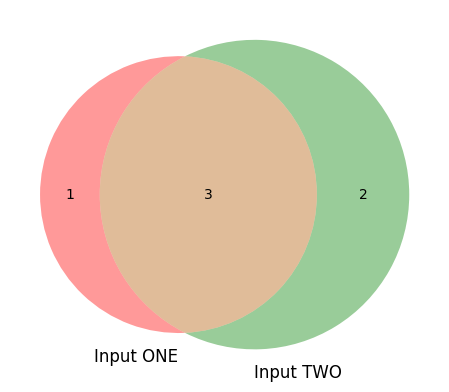

In [263]:
# Demo 1
# Compares TRAPI and Cypher (robokopkg) sets
#  -Added misspelling to TRAPI to give a unique result
#  -Also added one extra occurrence to TRAPI to demonstrate different number of occurrences

output_file_name = os.path.join(write_dir,"compare_trapi_cypher_robokopkg.txt")
compare_results(dict_trapi,dict_cypher_robokopkg, output_file_name)

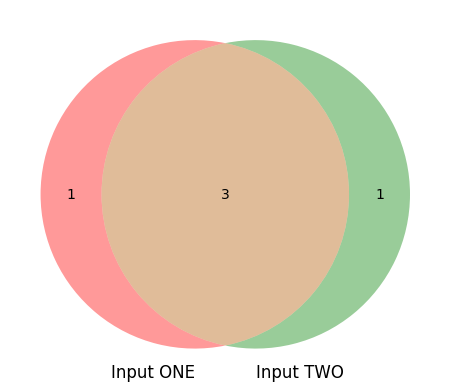

In [264]:
# Demo 2
# Compares TRAPI and Cypher (automat) sets
#  -Added misspelling to TRAPI to give a unique result
#  -Also added one extra occurrence to TRAPI to demonstrate different number of occurrences

output_file_name = os.path.join(write_dir,"compare_trapi_cypher_automat.txt")
compare_results(dict_trapi, dict_cypher_automat, output_file_name)

## Development section for function compare_result()

Comparing TRAPI and robokopkg output in the test folder

In [230]:
# Outputting to log file for common edges
print(f"Common edges: ")
common_edges = set(dict_trapi.items()).intersection(set(dict_cypher_robokopkg.items()))
for edge in common_edges:
    print(f"\t{edge[0]} - {edge[1]}")

Common edges: 
	CYP2D6 -> biolink:affects -> Buprenorphine - 1
	CYP2D6 -> biolink:genetic_association -> Tremor - 2


In [233]:
# Outputting to log file for common edges with different counts

for key in dict_cypher_robokopkg.keys():
    if key in dict_trapi.keys():
        if dict_cypher_robokopkg[key] == dict_trapi[key]:
            print(f"Common edge found: {key} - {dict_trapi[key]}")
        else:
            print(f"{key}\n\tCypher ROBOKOPKG - {dict_cypher_robokopkg[key]}\n\tTRAPI - {dict_trapi[key]}")
    else:
        print(f"Cypher ROBOKOPKG only: {key} - {dict_cypher_robokopkg[key]}")

for key in dict_trapi.keys():
    if key not in dict_cypher_robokopkg.keys():
        print(f"TRAPI only: {key} - {dict_trapi[key]}")

# set_cypher_kg = set(dict_cypher_robokopkg.items()).difference(set(dict_trapi.items()))
# cypher_kg_edges = set(map(lambda x: x[0], set_cypher_kg))
# cypher_kg_edges_counts = set(map(lambda x: x[1], set_cypher_kg))

# set_trapi = set(dict_trapi.items()).difference(set(dict_cypher_robokopkg.items()))
# trapi_edges = set(map(lambda x: x[0], set_trapi))
# trapi_edges_counts = set(map(lambda x: x[1], set_trapi))

Buprenorphine -> biolink:affects -> CYP2D6
	Cypher ROBOKOPKG - 1
	TRAPI: 2
Common edge found: CYP2D6 -> biolink:genetic_association -> Tremor - 2
Common edge found: CYP2D6 -> biolink:affects -> Buprenorphine - 1
Cypher ROBOKOPKG only: Buprenorphine -> biolink:regulates -> CYP2D6 - 1
Cypher ROBOKOPKG only: Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6 - 1
TRAPI only: Buprenorphine -> biolink:directctly_physically_interacts_with -> CYP2D6 - 1


In [241]:
# Outputting to log file for common edges with different counts

common_edge_same_list = []
common_edge_diff_list = []
cypher_robokopkg_only_list = []
trapi_only_list = []
for key in dict_cypher_robokopkg.keys():
    if key in dict_trapi.keys():
        if dict_cypher_robokopkg[key] == dict_trapi[key]:
            common_edge_same_list.append(f"{key} - {dict_trapi[key]}")
        else:
            common_edge_diff_list.append(f"{key}\n\tCypher ROBOKOPKG - {dict_cypher_robokopkg[key]}\n\tTRAPI - {dict_trapi[key]}")
    else:
        cypher_robokopkg_only_list.append(f"{key} - {dict_cypher_robokopkg[key]}")

for key in dict_trapi.keys():
    if key not in dict_cypher_robokopkg.keys():
        trapi_only_list.append(f"{key} - {dict_trapi[key]}")

print("Common edges:")
# pp.pprint(common_edge_same_list)
for edge in common_edge_same_list:
    print(edge)
print("\nCommon edges with different count:")
# pp.pprint(common_edge_diff_list)
for edge in common_edge_diff_list:
    print(edge)
print("\nCypher ROBOKOPKG only:")
# pp.pprint(cypher_robokopkg_only_list)
for edge in cypher_robokopkg_only_list:
    print(edge)
print("\nTRAPI only:")
# pp.pprint(trapi_only_list)
for edge in trapi_only_list:
    print(edge)

Common edges:
CYP2D6 -> biolink:genetic_association -> Tremor - 2
CYP2D6 -> biolink:affects -> Buprenorphine - 1

Common edges with different count:
Buprenorphine -> biolink:affects -> CYP2D6
	Cypher ROBOKOPKG - 1
	TRAPI - 2

Cypher ROBOKOPKG only:
Buprenorphine -> biolink:regulates -> CYP2D6 - 1
Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6 - 1

TRAPI only:
Buprenorphine -> biolink:directctly_physically_interacts_with -> CYP2D6 - 1


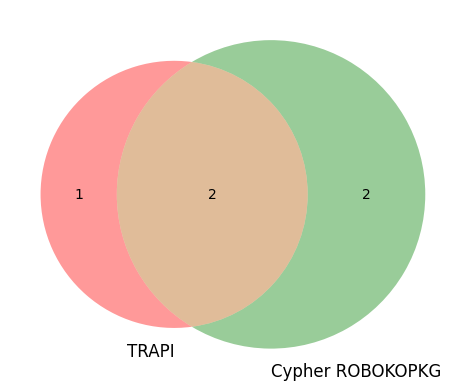

In [237]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (len(trapi_only_list), len(cypher_robokopkg_only_list), len(common_edge_same_list)), set_labels = ('TRAPI', 'Cypher ROBOKOPKG'))
plt.show()